## 1. Imports

In [1]:
!pip install openai==0.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#extract zip folder
!unzip '/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/Project/UNGDC19702018.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Converted sessions/Session 63 - 2008/PHL_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._PHL_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/DZA_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._DZA_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/MEX_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._MEX_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/AUT_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._AUT_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/COG_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._COG_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/CYP_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._CYP_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/SLB_63_2008.txt  

In [4]:
# Path to the folder containing sessions
base_path = 'Converted sessions/'

In [35]:
# Import Libraries
import glob
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import openai
import random
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from wordcloud import WordCloud

## 2. Preprocessing

In [6]:
# function to clean text
def clean(text):
      # removing paragraph numbers
      text = re.sub('[0-9]+.\t', '', text)
      # removing new line characters
      text = re.sub('\n', '', text)
      text = re.sub('\n', ' ', text)
      # remove apostrophes
      text = re.sub("'s", '', text)
      # replacing hyphen with blank space
      text = re.sub('-', ' ', text)
      text = re.sub('- ', '', text)
      # remove quotation marks
      text = re.sub('\"', '', text)
      # removing slautations
      text = re.sub('Mr\.', 'Mr', text)
      text = re.sub('Mrs\.', 'Mrs', text)
      text = re.sub('Ms\.', 'Ms', text)
      text = re.sub('Dr\.', 'Dr', text)
      # remove whitespaces
      text = text.strip()
      #removing reference to outside text
      text = re.sub('[\(\[].*?[\)\])]', '', text)
      # removing extra spaces
      text = re.sub(' +', ' ', text)
      return text

In [7]:
# function to split text into sentences
def sentences(text):
      text = re.split('[.?!]', text)
      clean_sent = []
      for sent in text:
        if sent != '':
          clean_sent.append(sent)
      return clean_sent

## 3. Topic Extraction Using **Topic GPT**

In [25]:
# Set your OpenAI API key from the environment variable
openai.api_key = ''

In [36]:
def extract_topics_single(speech, num_topics=1, num_words=5):
    prompt = f"Extract {num_topics} topics from the following speech. For each topic, provide {num_words} keywords:\n\n{speech}\n\nTopics:"

    response = None
    for attempt in range(5):
        try:
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are an assistant that extracts topics from speeches."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=200,
                n=1,
                stop=None,
                temperature=0.5,
            )
            break  # Exit loop if request is successful
        except openai.error.RateLimitError:
            wait_time = 2 ** attempt + random.uniform(0, 1)
            print(f"Rate limit exceeded. Attempt {attempt + 1}. Retrying in {wait_time:.2f} seconds...")
            time.sleep(wait_time)
        except Exception as e:
            print(f"An error occurred: {e}")
            break

    if response is None:
        raise Exception("Failed to retrieve response after several attempts.")

    topics_text = response.choices[0].message['content'].strip()
    topics = topics_text.split("\n")

    return topics  # Return topics as a list of strings

In [40]:
# Create a dataframe by consolidating all the information from the files
data = []
base_path = 'Converted sessions/'
for session_folder in sorted(glob.glob(base_path + 'Session*')):
    session = session_folder.split('/')[-1]
    year = session.split()[-1]
    if 1971 <= int(year) <= 2018:
        for file_path in glob.glob(session_folder + '/*.txt'):
            country_code = os.path.basename(file_path).split('_')[0]
            with open(file_path, 'r', encoding='utf-8') as file:
                speech = file.read()
                cleaned_speech = clean(speech)
                cleaned_sentences = sentences(cleaned_speech)
                combined_speech = " ".join(cleaned_speech) if isinstance(cleaned_speech, list) else cleaned_speech
                topics = extract_topics_single(combined_speech)  # Extract topics for each speech
            print('Country:', country_code, 'Session:', session)
            data.append({
                'Country': country_code,
                'Session': session,
                'Year': year,
                'Speech': cleaned_sentences,
                'Topics': topics  # Topics stored as a list
            })

df = pd.DataFrame(data)

Streaming output truncated to the last 5000 lines.
Rate limit exceeded. Attempt 2. Retrying in 2.53 seconds...
Rate limit exceeded. Attempt 3. Retrying in 4.80 seconds...
Country: SAU Session: Session 67 - 2012
Rate limit exceeded. Attempt 1. Retrying in 1.93 seconds...
Rate limit exceeded. Attempt 2. Retrying in 2.61 seconds...
Country: SLB Session: Session 67 - 2012
Rate limit exceeded. Attempt 1. Retrying in 1.07 seconds...
Rate limit exceeded. Attempt 2. Retrying in 2.38 seconds...
Rate limit exceeded. Attempt 3. Retrying in 4.21 seconds...
Country: GHA Session: Session 67 - 2012
Rate limit exceeded. Attempt 1. Retrying in 1.26 seconds...
Rate limit exceeded. Attempt 2. Retrying in 2.85 seconds...
Rate limit exceeded. Attempt 3. Retrying in 4.20 seconds...
Country: PAK Session: Session 67 - 2012
Rate limit exceeded. Attempt 1. Retrying in 1.53 seconds...
Rate limit exceeded. Attempt 2. Retrying in 2.02 seconds...
Rate limit exceeded. Attempt 3. Retrying in 4.95 seconds...
Country: 

In [41]:
df.to_pickle('df_with_topic_gpt_topics.pkl')

In [143]:
df = pd.read_pickle('df_with_topic_gpt_topics.pkl')

## 4. Data Exploration

In [128]:
df.shape

(8023, 5)

In [129]:
df.head()

,Country,Session,Year,Speech,Topics
0,ZAF,Session 26 - 1971,1971,"[Mr President, I am glad to have the opportuni...",[Topic: Progress towards self-determination in...
1,ECU,Session 26 - 1971,1971,[The Government of Ecuador wishes to extend co...,[1. United Nations and International Relations...
2,MNG,Session 26 - 1971,1971,"[Mr President, may I, on behalf of the delegat...","[1. International Peace and Security, Keywo..."
3,GUY,Session 26 - 1971,1971,"[Mr, President, may I join with all those who ...",[1. Universality of Membership in the United N...
4,ISL,Session 26 - 1971,1971,"[Mr President, at the outset of my statement I...",[Topic: United Nations and International Relat...


In [100]:
df.Speech[67]

['I should like, Sir, on behalf of the Irish delegation, to add my warm congratulations on your election as President of the twenty sixth session of the General Assembly',
 ' The Assembly has chosen a President who knows how to bear wisdom lightly and, in electing you to this high honor, has paid tribute to you as a distinguished leader and statesman of your great country, a country of rich cultural diversity in unity and one which has such an important role in the affairs of your region and among all the nations',
 'I am happy to join in the universal tribute that has also been paid to',
 ' Mr Hambro, the distinguished representative of Norway, whose patience, skill and dynamism were so brilliantly displayed as President of the twenty fifth session of the Assembly',
 '113',
 ' It is my pleasant duty to join in welcoming three new Member States, Bhutan, Bahrain and Qatar, Together they are further encouraging evidence of the spirit of freedom which has animated this Assembly from its b

In [144]:
df.Topics[67]

['1. International Relations',
 '   Keywords: United Nations, General Assembly, Member States, Peacekeeping, Security Council',
 '',
 'These keywords highlight the discussion on international relations, focusing on the role of the United Nations, peacekeeping efforts, and interactions between Member States in various global issues.']

In [145]:
df.Topics[56]

['Topic: International Relations',
 '',
 'Keywords:',
 '1. Australia',
 '2. Indonesia',
 '3. General Assembly',
 '4. United Nations',
 '5. Cooperation']

In [132]:
df.Topics[245]

['Topic: United Nations General Assembly',
 'Keywords: President, Secretary General, Member States, International cooperation, Peace efforts']

In [133]:
df.Topics[4245]

['Topic: United Nations Reform',
 'Keywords: Security Council, international relations, reform, solidarity, financial responsibility',
 '',
 'Topic: Human Rights',
 'Keywords: promotion, global approach, collaboration, Secretary General, international organizations',
 '',
 'Topic: Economic and Social Development',
 'Keywords: poverty, education, development, global tools, economic fluctuation',
 '',
 'Topic: Africa Development',
 'Keywords: Central Africa, cooperation, peace, stability, conflicts',
 '',
 'Topic: International Intervention',
 'Keywords: Security Council, humanitarian intervention, national sovereignty, Kosovo crisis']

In [134]:
df.Topics[7541]

['Topic 1: Sustainable Development Goals',
 'Keywords: 2030 Agenda, poverty eradication, inclusive societies, environmental sustainability, official development assistance']

In [146]:
df.Topics[5152]

['Topic: United Nations and Global Cooperation',
 '',
 'Keywords:',
 '1. General Assembly',
 '2. Multilateral action',
 '3. Development financing',
 '4. International cooperation',
 '5. Global economic order']

In [147]:
# Function to clean and extract the topic and keywords from a list
def extract_topic_keywords_from_list(topic_list):
    if isinstance(topic_list, list):
        combined_text = ' '.join(topic_list)
        topic_match = re.search(r"Topic:\s*(.+?)\s*(Keywords:)", combined_text)
        if topic_match:
            topic = topic_match.group(1)
        else:
            topic = None

        keywords_match = re.search(r"Keywords:\s*(.+)", combined_text)
        if keywords_match:
            keywords = keywords_match.group(1).split(', ')[:4]
        else:
            keywords = []

        return topic, keywords
    return None, None

# Apply the function to the DataFrame
df['Topic'] = df['Topics'].apply(lambda x: extract_topic_keywords_from_list(x)[0])
df['Keywords'] = df['Topics'].apply(lambda x: extract_topic_keywords_from_list(x)[1])

In [148]:
# Rename the column 'Topics' to 'Extracted_Topics'
df.rename(columns={'Topics': 'Extracted_Topics'}, inplace=True)

In [149]:
df['Topic'][5152]

'United Nations and Global Cooperation'

In [150]:
df['Keywords'][5152]

['1. General Assembly 2. Multilateral action 3. Development financing 4. International cooperation 5. Global economic order']

In [140]:
df['Keywords'][4552]

['Hiroshima', 'Nagasaki', 'nuclear weapons', 'disarmament']

In [113]:
df['Keywords'][451]

['President of the General Assembly',
 'non-aligned world',
 'United Nations membership',
 'global peace']

In [151]:
# Function to process keywords
def process_keywords(keywords):
    if isinstance(keywords, list) and len(keywords) == 1:
        # Convert the single element list to a string
        keywords_str = keywords[0]
        # Remove numbers followed by a dot and a space
        cleaned_keywords = re.sub(r'\d+\.\s*', '', keywords_str)
        # Split into a list based on the numbers and spaces
        keywords_list = re.split(r'\s+(?=\d+\.)', keywords_str)
        # Remove numbers and dots from each element in the list
        keywords_list = [re.sub(r'\d+\.\s*', '', kw).strip() for kw in keywords_list]
        return keywords_list[:5]  # Ensure the list contains only the first 5 elements
    elif isinstance(keywords, list):
        # Ensure the list contains only the first 4 elements
        return keywords[:4]
    return keywords

# Apply the function to the 'Keywords' column
df['Keywords'] = df['Keywords'].apply(process_keywords)

In [152]:
df['Keywords'][5152]

['General Assembly',
 'Multilateral action',
 'Development financing',
 'International cooperation',
 'Global economic order']

In [154]:
df['Topic'][5152]

'United Nations and Global Cooperation'

In [155]:
# Function to add the topic as the first element in the keywords list
def add_topic_to_keywords(row):
    return [row['Topic']] + row['Keywords']

# Apply the function to create the final list
df['Keywords'] = df.apply(add_topic_to_keywords, axis=1)

In [156]:
df['Keywords'][5152]

['United Nations and Global Cooperation',
 'General Assembly',
 'Multilateral action',
 'Development financing',
 'International cooperation',
 'Global economic order']

In [157]:
# Function to ensure each list in 'Keywords' has exactly 5 elements
def ensure_five_elements(keywords):
    return keywords[:5]

# Apply the function to the 'Keywords' column
df['Keywords'] = df['Keywords'].apply(ensure_five_elements)


In [160]:
# Rename the column 'Topics' to 'Extracted_Topics'
df.rename(columns={'Keywords': 'Topics'}, inplace=True)

In [161]:
df.Topics[5152]

['United Nations and Global Cooperation',
 'General Assembly',
 'Multilateral action',
 'Development financing',
 'International cooperation']

# Data Exploration

In [52]:
# create df['Word Count']
df['Word Count'] = df['Speech'].apply(lambda x: len(str(x).split()))

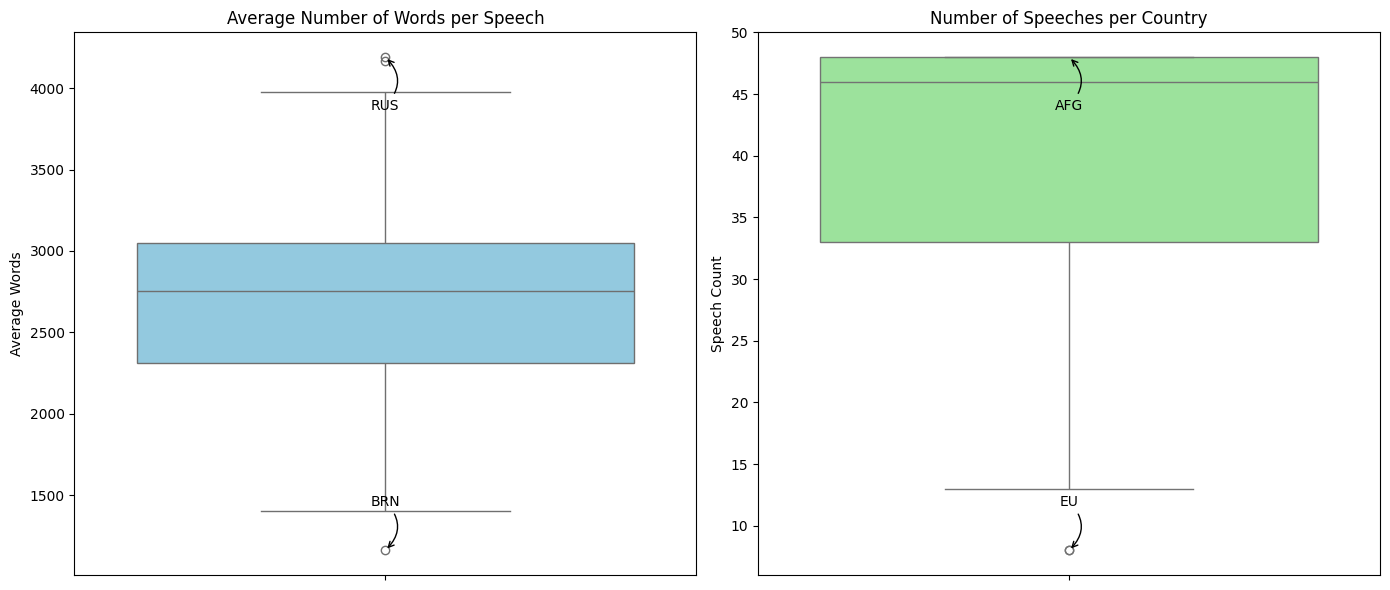

In [53]:
# Calculate average words per speech by country
avg_words_per_speech = df.groupby('Country')['Word Count'].mean()

# Calculate the number of speeches per country
speeches_per_country = df.groupby('Country').size()

# Create a figure for the plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for Average Number of Words per Speech
sns.boxplot(y=avg_words_per_speech, ax=ax[0], color='skyblue')
ax[0].set_title('Average Number of Words per Speech')
ax[0].set_ylabel('Average Words')

# Find and annotate the country with the max and min average words
max_words_country = avg_words_per_speech.idxmax()
min_words_country = avg_words_per_speech.idxmin()
ax[0].annotate(max_words_country,
               xy=(0, avg_words_per_speech[max_words_country]),
               xytext=(0, -40),
               textcoords='offset points',
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"),
               ha='center', va='bottom')
ax[0].annotate(min_words_country,
               xy=(0, avg_words_per_speech[min_words_country]),
               xytext=(0, 40),
               textcoords='offset points',
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.5"),
               ha='center', va='top')

# Boxplot for Number of Speeches per Country
sns.boxplot(y=speeches_per_country, ax=ax[1], color='lightgreen')
ax[1].set_title('Number of Speeches per Country')
ax[1].set_ylabel('Speech Count')

# Find and annotate the country with the max and min number of speeches
max_speeches_country = speeches_per_country.idxmax()
min_speeches_country = speeches_per_country.idxmin()
ax[1].annotate(max_speeches_country,
               xy=(0, speeches_per_country[max_speeches_country]),
               xytext=(0, -40),
               textcoords='offset points',
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"),
               ha='center', va='bottom')
ax[1].annotate(min_speeches_country,
               xy=(0, speeches_per_country[min_speeches_country]),
               xytext=(0, 40),
               textcoords='offset points',
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.5"),
               ha='center', va='top')

# Improve layout and display the plot
plt.tight_layout()
plt.show()


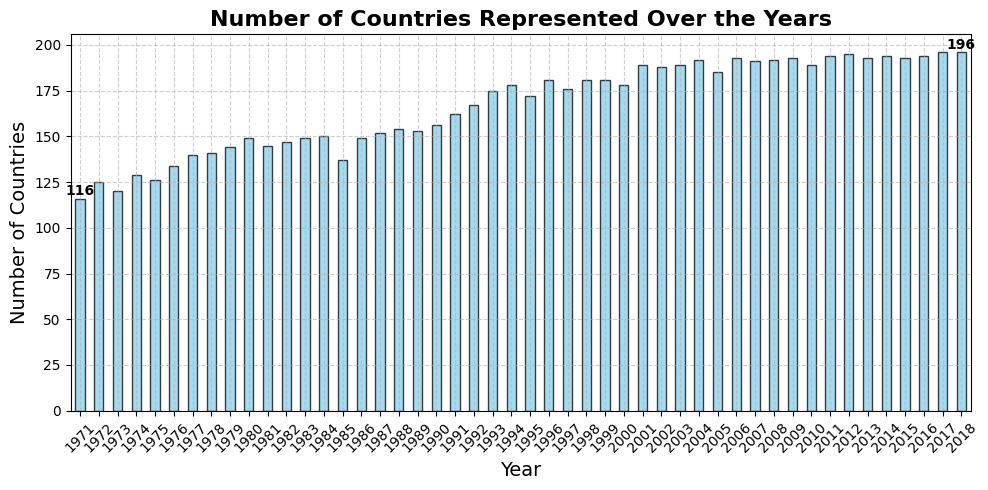

In [56]:
# Group by 'Year' and count unique 'Country' entries
country_counts_per_year = df.groupby('Year')['Country'].nunique()

# Plot the results
plt.figure(figsize=(10, 5))  # Increased size for better readability
ax = country_counts_per_year.plot(kind='bar', color='skyblue', alpha=0.75, edgecolor='black')
plt.title('Number of Countries Represented Over the Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Countries', fontsize=14)
plt.xticks(rotation=45)  # Rotate the x labels to make them more readable
plt.grid(True, linestyle='--', alpha=0.6)  # Make grid less pronounced
plt.tight_layout()  # Adjusts plot parameters to give some padding

# Add data labels to the first and the last bar
y_offset = 2  # Offset for label placement above the bar
for i, label in enumerate(list(country_counts_per_year.index)):
    count = country_counts_per_year[label]
    if i == 0 or i == len(country_counts_per_year) - 1:  # Check for first or last bar
        ax.text(i, count + y_offset, f'{count}', ha='center', color='black', fontweight='bold')

plt.show()


In [165]:
# Flatten the list of topics from each sublist directly, and split each topic by commas, handling None values
individual_terms = [term.strip() for sublist in df['Topics'] if sublist is not None
                   for topic in sublist if topic is not None # Check if topic is not None before splitting
                   for term in topic.split(', ')]

# Count the frequencies of each individual term
term_counts = Counter(individual_terms)

# Sort the terms by frequency in descending order
sorted_terms = dict(sorted(term_counts.items(), key=lambda item: item[1], reverse=True))

In [167]:
# Print the top 25 most frequent topics
top_25_topics = list(sorted_terms.items())[:25]
print("Topic GPT: Top 25 Most Frequent Topics:\n")
for topic, count in top_25_topics:
    print(f"{topic}: {count}")


Topic GPT: Top 25 Most Frequent Topics:

United Nations: 3496
General Assembly: 2110
International Relations: 878
Security Council: 863
Secretary General: 795
Terrorism: 532
Peace: 463
United Nations and International Relations: 431
United Nations Reform: 423
peace: 402
International cooperation: 392
Millennium Development Goals: 322
Human rights: 321
President: 309
Peacekeeping: 304
Conflict resolution: 303
Disarmament: 296
Multilateralism: 243
international community: 235
Climate change: 226
International Relations and Diplomacy: 216
Peace and security: 209
Sustainable development: 194
Diplomacy: 192
cooperation: 187


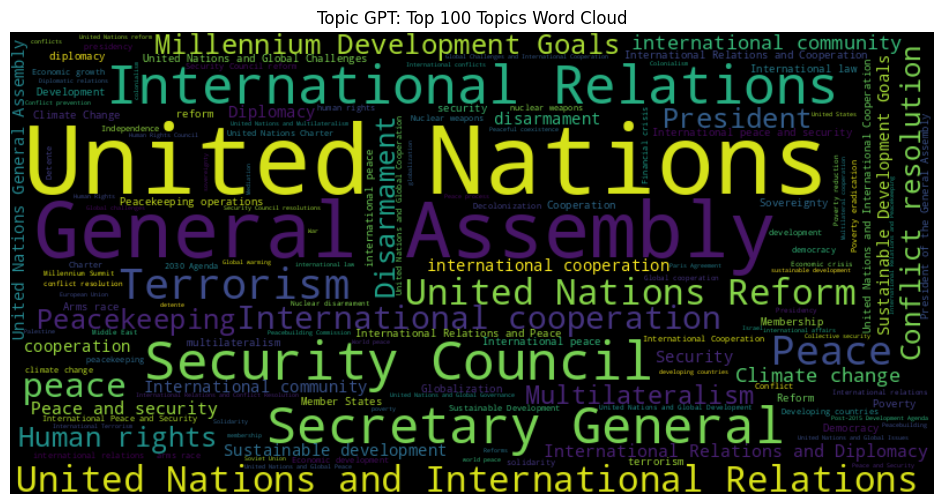

In [168]:
# Create a word cloud from the sorted topic frequencies
wordcloud = WordCloud(width=800, height=400, max_words=250).generate_from_frequencies(sorted_terms)

# Plot the word cloud
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Topic GPT: Top 100 Topics Word Cloud')
plt.show()


## 5. Clustering

In [169]:
# Aggregate topics by country across all years
aggregated_topics = df.groupby('Country')['Topics'].agg(sum).reset_index()

# Create a new DataFrame with just the 'Country' and 'Topics'
final_df = pd.DataFrame({
    'Country': aggregated_topics['Country'],
    'Topics': aggregated_topics['Topics']
})

# Display the resulting DataFrame
print(final_df.head())

  Country                                             Topics
0     AFG  [None, President of the General Assembly, Unit...
1     AGO  [International Relations, United Nations, Peac...
2     ALB  [None, None, United Nations, imperialist Power...
3     AND  [None, micro states, international relations, ...
4     ARE  [International Relations, Arab nation, League ...


In [172]:
# Convert list of topics to a single string per country, handling None values
final_df['Topics_Str'] = final_df['Topics'].apply(lambda x: ' '.join([str(i) for i in x if i is not None]))

In [173]:
# create tfidf vectors
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(final_df['Topics_Str'])

# Initialize variables to store the best configuration
best_score = -1
best_params = None

# Define a range of parameters
params_grid = {
    'n_clusters': [2, 3, 4, 5],
    'init': ['k-means++', 'random'],
    'n_init': [10, 15, 20]
}

# Apply TF-IDF from previous steps
for k in params_grid['n_clusters']:
    for init_method in params_grid['init']:
        for n_init_val in params_grid['n_init']:
            kmeans = KMeans(n_clusters=k, init=init_method, n_init=n_init_val, random_state=42)
            cluster_labels = kmeans.fit_predict(tfidf_matrix)
            silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)

            # Check if the current configuration is better
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = {'n_clusters': k, 'init': init_method, 'n_init': n_init_val}

# Output the best configuration
print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)

# Save the best parameters
kmeans_final = KMeans(n_clusters=best_params['n_clusters'], init=best_params['init'], n_init=best_params['n_init'], random_state=42)
clusters = kmeans_final.fit_predict(tfidf_matrix)


Best Silhouette Score: 0.2139322569287012
Best Parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 10}


In [174]:
# Addition of Cluster to the dataframe with best parameters
final_df['Cluster'] = kmeans_final.fit_predict(tfidf_matrix)

# Print the final DataFrame with clusters assigned
print(final_df[['Country', 'Cluster']].head(10))

  Country  Cluster
0     AFG        1
1     AGO        1
2     ALB        1
3     AND        0
4     ARE        1
5     ARG        1
6     ARM        1
7     ATG        0
8     AUS        1
9     AUT        1


In [175]:
dense_tfidf_matrix = tfidf_matrix.todense()
# Convert the dense_tfidf_matrix to a NumPy array
dense_tfidf_array = np.asarray(dense_tfidf_matrix)

# Create a PCA instance with 2 components
pca = PCA(n_components=2)

# Fit the PCA instance to the dense_tfidf_array
reduced_features = pca.fit_transform(dense_tfidf_array)


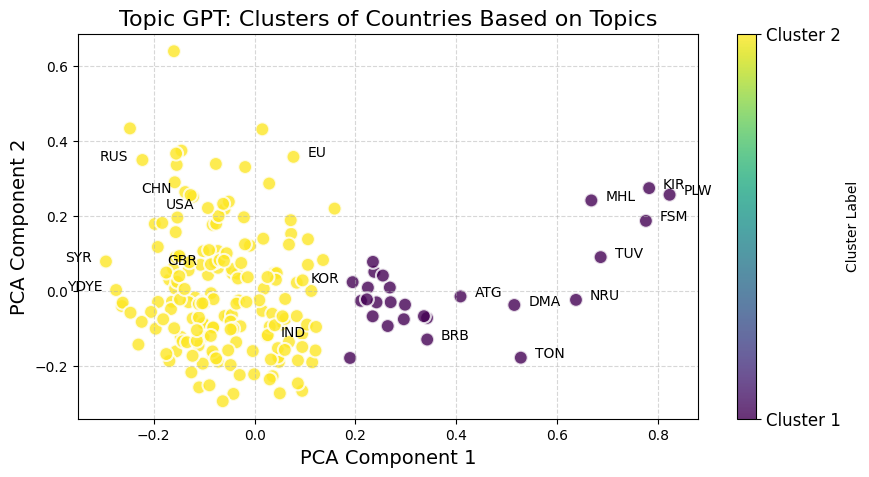

In [186]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_df contains the countries and reduced_features contains the PCA components

# Function to determine text position to avoid overlap in the plot
def adjust_text_position(x, y, text, ax):
    if x > 0:
        return ax.annotate(text, (x, y), textcoords="offset points", xytext=(10,0), ha='left')
    else:
        return ax.annotate(text, (x, y), textcoords="offset points", xytext=(-10,0), ha='right')

# Create the scatter plot with PCA components
plt.figure(figsize=(10, 5))
# Adjust the number of colors in cmap to match the number of clusters
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=100, alpha=0.8, edgecolors='w', linewidths=1.5)
plt.title('Topic GPT: Clusters of Countries Based on Topics', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
cbar = plt.colorbar(scatter, label='Cluster Label', ticks=range(2))  # Ensure colorbar only shows two ticks
cbar.ax.set_yticklabels(['Cluster 1', 'Cluster 2'])  # Label the clusters
cbar.ax.tick_params(labelsize=12)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Identify the indices of the countries to be labeled
countries_to_label = ['USA', 'RUS', 'CHN', 'KOR', 'EU', 'GBR', 'IND']

# Identify the top 10 countries with the maximum PCA Component 1 values
max_2_indices = np.argsort(reduced_features[:, 0])[-10:]
max_2_countries = final_df.iloc[max_2_indices]['Country'].tolist()

# Identify the bottom 4 countries with the minimum PCA Component 1 values
min_2_indices = np.argsort(reduced_features[:, 0])[:2]
min_2_countries = final_df.iloc[min_2_indices]['Country'].tolist()

# Combine all countries to be labeled
all_countries_to_label = countries_to_label + max_2_countries + min_2_countries

# Annotate the specified countries
for i, country in enumerate(final_df['Country']):
    if country in all_countries_to_label:
        adjust_text_position(reduced_features[i, 0], reduced_features[i, 1], country, plt.gca())

plt.show()


In [182]:
# Flatten the list of topics from each sublist directly, and split each topic by commas
individual_terms_cluster_0 = [
    term.strip()
    for sublist in final_df[final_df['Cluster'] == 0]['Topics']
    for topic in sublist
    if topic is not None  # Skip None values
    for term in topic.split(', ')
]
individual_terms_cluster_1 = [
    term.strip()
    for sublist in final_df[final_df['Cluster'] == 1]['Topics']
    for topic in sublist
    if topic is not None  # Skip None values
    for term in topic.split(', ')
]

# Convert lists of terms into single strings for word cloud generation
text_cluster_0 = ' '.join(individual_terms_cluster_0)
text_cluster_1 = ' '.join(individual_terms_cluster_1)

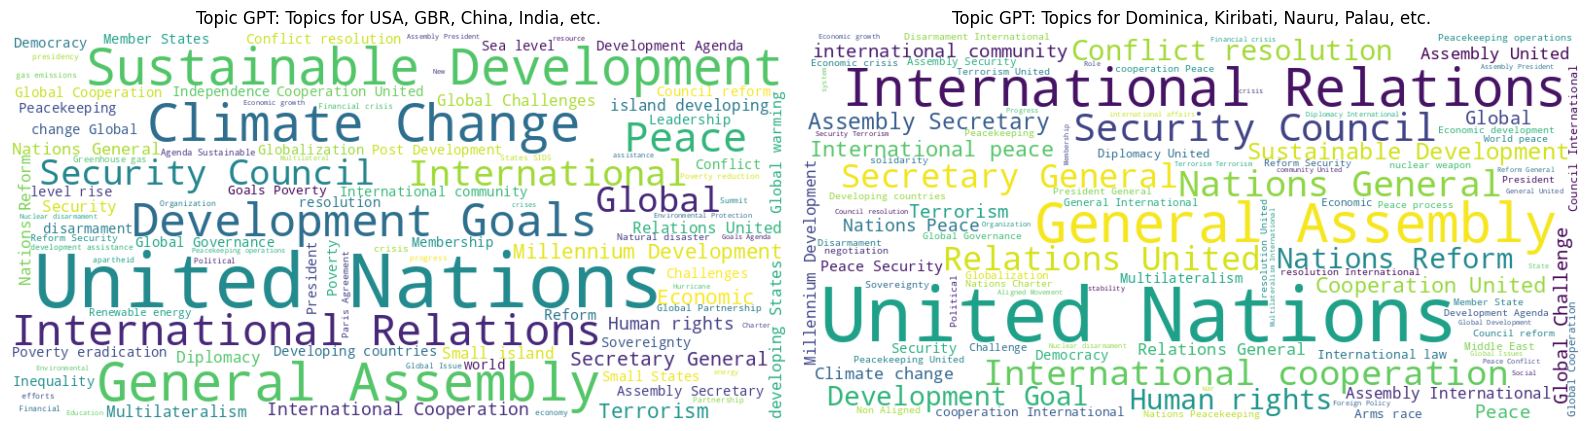

In [185]:
# Function to generate and display word clouds for both clusters side by side
def generate_word_clouds(text_cluster_0, text_cluster_1):
    # Set up the matplotlib figure and subplots
    plt.figure(figsize=(16, 8))  # Overall figure size

    # Subplot for Cluster 0
    ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    wordcloud0 = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text_cluster_0)
    ax1.imshow(wordcloud0, interpolation='bilinear')
    ax1.axis('off')  # No axis for word cloud
    ax1.set_title('Topic GPT: Topics for USA, GBR, China, India, etc.')

    # Subplot for Cluster 1
    ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    wordcloud1 = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text_cluster_1)
    ax2.imshow(wordcloud1, interpolation='bilinear')
    ax2.axis('off')  # No axis for word cloud
    ax2.set_title('Topic GPT: Topics for Dominica, Kiribati, Nauru, Palau, etc.')

    # Show the plot
    plt.tight_layout()  # Adjusts subplots to give some padding between them
    plt.show()

generate_word_clouds(text_cluster_0, text_cluster_1)


Major Geopolitical Players: The larger and more influential countries discuss a broad spectrum of topics, including UN reforms, international security, sustainable development, and global governance. Their speeches reflect their involvement in shaping global policies and addressing worldwide issues.

Smaller or Regional Players: These countries focus more on specific issues that directly impact them, such as sustainable development, environmental concerns, and regional stability. Their speeches are centered around garnering support for their developmental needs and ensuring their voices are heard in global discussions.

These visualizations highlight the differences in focus and priorities between major global players and smaller nations in the UN General Assembly, reflecting their respective geopolitical positions and concerns.
